In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter


# 1. Caricamento del dataset
file_name = "tripadvisor_hotel_reviews.csv"
df = pd.read_csv(file_name)


/var/folders/5b/rfn7xdc94xd8twd00cctt7qm0000gn/T/ipykernel_10090/2023361817.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


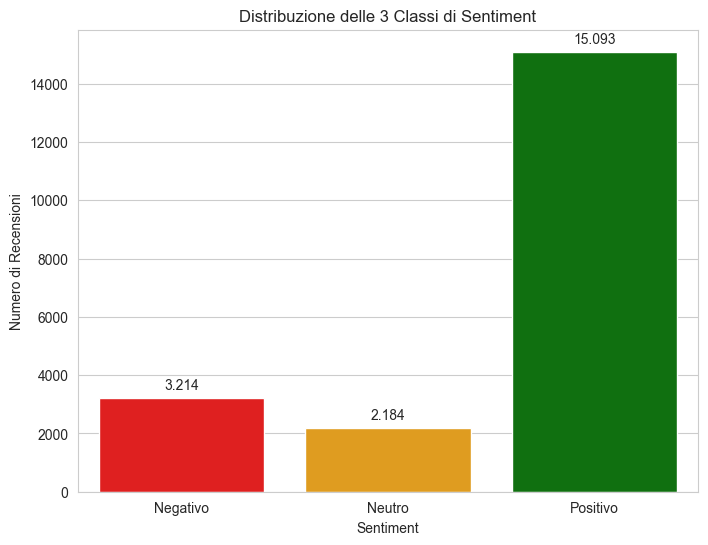

In [104]:
# Imposta lo stile di Seaborn per grafici più belli
sns.set_style("whitegrid")

# 1. Caricamento del dataset
file_name = "tripadvisor_hotel_reviews.csv"
df = pd.read_csv(file_name)

# 2. Definizione delle 3 classi di Sentiment
# Rating 1, 2 -> Negativo
# Rating 3 -> Neutro
# Rating 4, 5 -> Positivo
def map_sentiment_3_classes(rating):
    if rating <= 2:
        return 'Negativo'
    elif rating == 3:
        return 'Neutro'
    else:
        return 'Positivo'

df['Sentiment_Label'] = df['Rating'].apply(map_sentiment_3_classes)

# 3. Conteggio e preparazione dei dati per il grafico
sentiment_counts = df['Sentiment_Label'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Conteggio']

# Ordiniamo per visualizzare in ordine logico: Negativo, Neutro, Positivo
order = ['Negativo', 'Neutro', 'Positivo']
sentiment_counts['Sentiment'] = pd.Categorical(
    sentiment_counts['Sentiment'], categories=order, ordered=True
)
sentiment_counts = sentiment_counts.sort_values('Sentiment')

# 4. Creazione dell'Istogramma (Bar Plot)
plt.figure(figsize=(8, 6))
# Definisci una palette di colori per distinguere le classi
palette = {'Negativo': 'red', 'Neutro': 'orange', 'Positivo': 'green'}

ax = sns.barplot(
    x='Sentiment',
    y='Conteggio',
    data=sentiment_counts,
    palette=palette 
)

# Aggiungi i valori numerici sopra le barre
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height()):,}'.replace(',', '.'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontsize=10
    )

plt.title('Distribuzione delle 3 Classi di Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Numero di Recensioni')
plt.show()
plt.close()

In [105]:
#Classificazione senza SMOTE e Under-sampling
# Verifichiamo il bilanciamento delle nuove classi
print("Distribuzione delle classi a 3 livelli:")
print(df['Sentiment_Label'].value_counts().to_markdown())

# Variabili indipendenti (X) e dipendenti (y)
X = df['Review']
y = df['Sentiment_Label']
# 3. Vettorizzazione del Testo (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_vectorized = vectorizer.fit_transform(X)

# 4. Suddivisione del dataset in set di Addestramento e Test
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Addestramento del Modello (Regressione Logistica)
model = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42)
model.fit(X_train, y_train)

# 6. Valutazione del Modello
y_pred = model.predict(X_test)

print("\nReport di Classificazione (Regressione Logistica - 3 Classi):")
target_names = ['Negativo (0)', 'Neutro (1)', 'Positivo (2)']
print(classification_report(y_test, y_pred, target_names=target_names))

Distribuzione delle classi a 3 livelli:
| Sentiment_Label   |   count |
|:------------------|--------:|
| Positivo          |   15093 |
| Negativo          |    3214 |
| Neutro            |    2184 |


/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



Report di Classificazione (Regressione Logistica - 3 Classi):
              precision    recall  f1-score   support

Negativo (0)       0.83      0.77      0.80       643
  Neutro (1)       0.54      0.11      0.19       437
Positivo (2)       0.87      0.98      0.92      3019

    accuracy                           0.86      4099
   macro avg       0.75      0.62      0.64      4099
weighted avg       0.83      0.86      0.82      4099



In [106]:
#Classificazione con SMOTE e Under-sampling combinati

X = df['Review']

y_encoded, y_levels = pd.factorize(df['Sentiment_Label'], sort=True) 
# Le classi numeriche finali sono: 0='Negativo', 1='Neutro', 2='Positivo'
y = y_encoded

# 2. Suddivisione in set di Addestramento e Test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Vettorizzazione del Testo (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train_raw)
X_test_vectorized = vectorizer.transform(X_test_raw)

# 4. Bilanciamento Combinato (Over-sampling + Under-sampling)
# Si definisce il numero desiderato di campioni per ogni classe nel set di addestramento.
# La classe Positivo nel training ha circa 12000 campioni (15093 * 0.8).
sampling_strategy = {
    0: 8000, # Negativo (oversampling)
    1: 8000, # Neutro (oversampling)
    2: 8000  # Positivo (undersampling)
}

# Creiamo una pipeline per combinare le operazioni in sequenza:
# Prima: Aumentiamo Negativo e Neutro con SMOTE.
# Dopo: Riduciamo Positivo a 10000 con RandomUnderSampler.
over = SMOTE(sampling_strategy={0: 8000, 1: 8000}, random_state=42)
under = RandomUnderSampler(sampling_strategy={2: 8000}, random_state=42)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Applica la pipeline di bilanciamento al set di addestramento vettorizzato
X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train_vectorized, y_train)

# Verifica la distribuzione dopo il bilanciamento
print("\nDistribuzione delle classi nel set di addestramento DOPO Bilanciamento Combinato:")
print(pd.Series(y_train_balanced).value_counts()) 


# 5. Addestramento e Valutazione del Modello
model = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42, max_iter=1000)
model.fit(X_train_balanced, y_train_balanced)

# 6. Valutazione sul set di Test (non bilanciato)
y_pred = model.predict(X_test_vectorized)

print("\nReport di Classificazione DOPO Bilanciamento Combinato (SMOTE + Under-sampling):")
target_names = ['Negativo (0)', 'Neutro (1)', 'Positivo (2)']
print(classification_report(y_test, y_pred, target_names=target_names))


Distribuzione delle classi nel set di addestramento DOPO Bilanciamento Combinato:
0    8000
1    8000
2    8000
Name: count, dtype: int64


/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



Report di Classificazione DOPO Bilanciamento Combinato (SMOTE + Under-sampling):
              precision    recall  f1-score   support

Negativo (0)       0.73      0.79      0.76       643
  Neutro (1)       0.32      0.47      0.38       437
Positivo (2)       0.94      0.86      0.90      3019

    accuracy                           0.81      4099
   macro avg       0.66      0.71      0.68      4099
weighted avg       0.84      0.81      0.82      4099



/var/folders/5b/rfn7xdc94xd8twd00cctt7qm0000gn/T/ipykernel_10090/3828695381.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


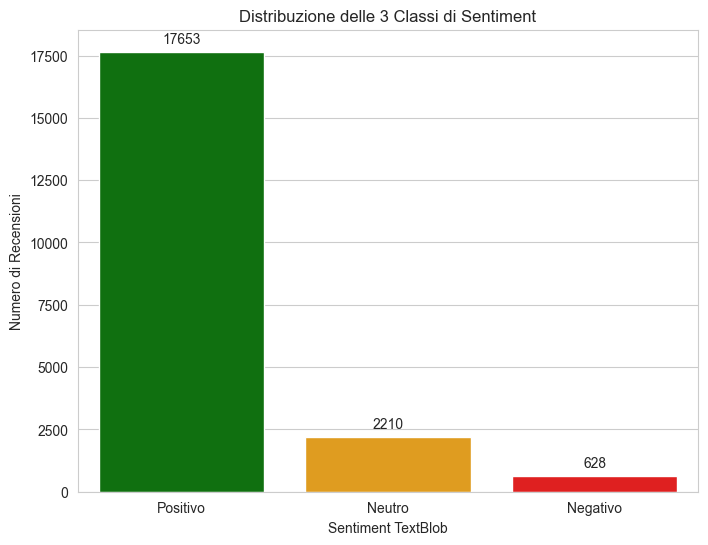

In [107]:
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 3. Applicazione della Sentiment Analysis con TextBlob
# Estrae la polarità (-1.0 a +1.0)
df['Polarity'] = df['Review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['Subjectivity'] = df['Review'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Mappa la polarità in classi di sentiment
def map_polarity_to_sentiment(polarity):
    if polarity < -0.1:
        return 'Negativo'
    elif polarity > 0.1:
        return 'Positivo'
    else:
        return 'Neutro'
    

df['TextBlob_Sentiment'] = df['Polarity'].apply(map_polarity_to_sentiment)

sentiment_counts_textblob = df['TextBlob_Sentiment'].value_counts().reset_index()
sentiment_counts_textblob.columns = ['Sentiment', 'Conteggio']
# 3. Istogramma (Bar Plot)
plt.figure(figsize=(8, 6))

palette = {'Negativo': 'red', 'Neutro': 'orange', 'Positivo': 'green'}

ax = sns.barplot(
    data=sentiment_counts_textblob,
    x='Sentiment',
    y='Conteggio',
    palette=palette
)

# 4. Etichette sopra le barre
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 9),
        textcoords='offset points'
    )

plt.title('Distribuzione delle 3 Classi di Sentiment')
plt.xlabel('Sentiment TextBlob')
plt.ylabel('Numero di Recensioni')
plt.show()
plt.close()

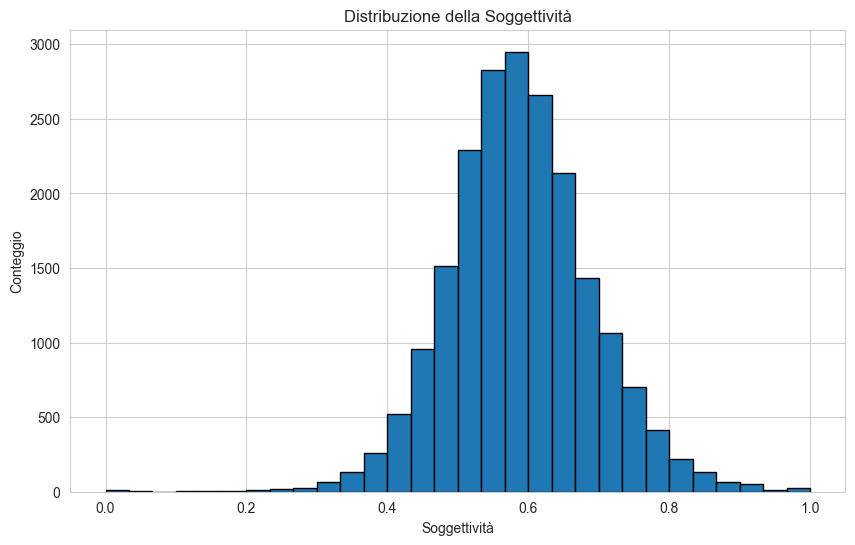

In [108]:
plt.figure(figsize=(10, 6))
plt.hist(df["Subjectivity"], bins=30, edgecolor='black')
plt.title("Distribuzione della Soggettività")
plt.xlabel("Soggettività")
plt.ylabel("Conteggio")
plt.show()

Generazione Word Cloud per Recensioni Positive


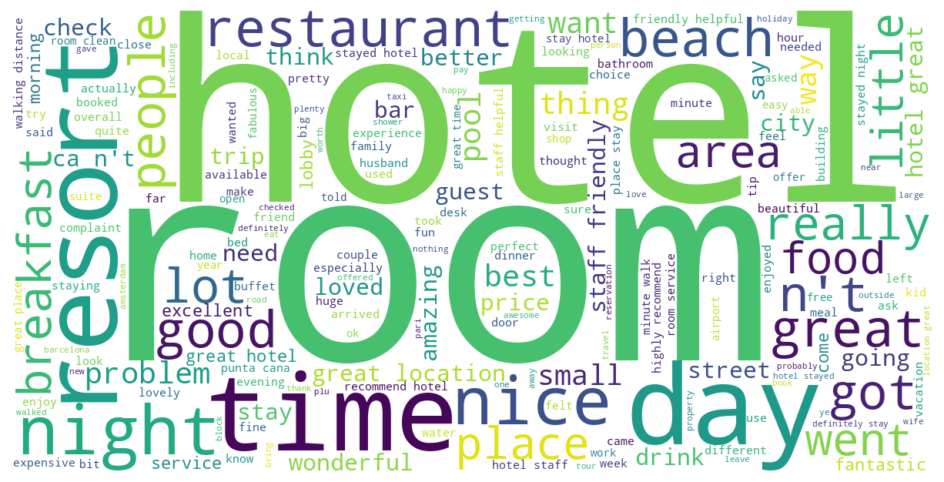

Generazione Word Cloud per Recensioni Negative


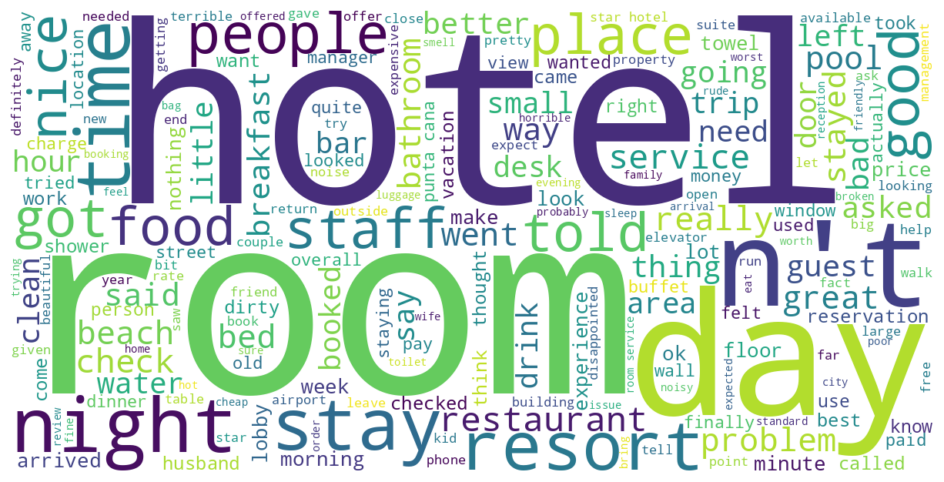

Generazione Word Cloud per Recensioni Neutre


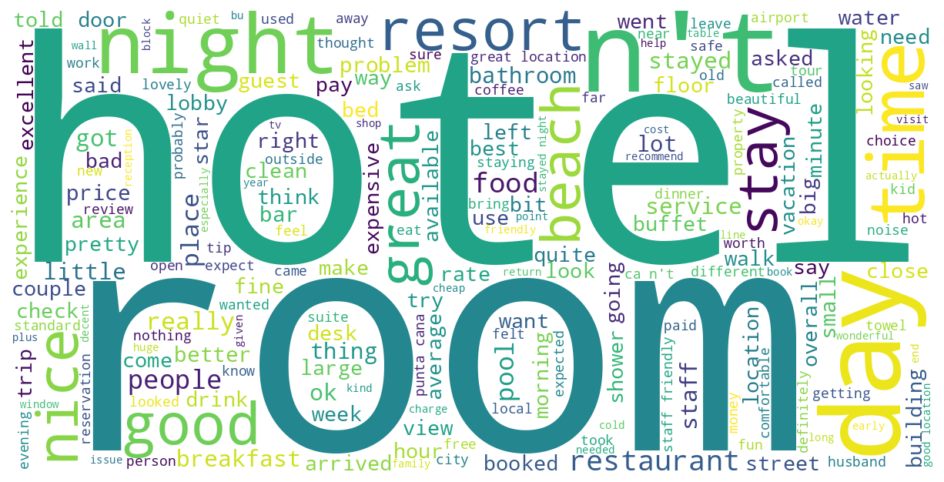

In [109]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_positive = df[df['Sentiment_Label'] == 'Positivo']
df_negative = df[df['Sentiment_Label'] == 'Negativo']
df_neutral = df[df['Sentiment_Label'] == 'Neutro']

# Unisci tutte le recensioni in un unico testo
print("Generazione Word Cloud per Recensioni Positive")
all_text_pos = " ".join(df_positive['Review'].astype(str))

wordcloud_pos = WordCloud(
    width=1200,
    height=600,
    background_color='white'
).generate(all_text_pos)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.show()

print("Generazione Word Cloud per Recensioni Negative")
all_text_neg = " ".join(df_negative['Review'].astype(str))

wordcloud_neg = WordCloud(
    width=1200,
    height=600,
    background_color='white'
).generate(all_text_neg)   

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.show()

print("Generazione Word Cloud per Recensioni Neutre")
all_text_neutral = " ".join(df_neutral['Review'].astype(str))

wordcloud_neutral = WordCloud(
    width=1200,
    height=600,
    background_color='white'
).generate(all_text_neutral)   
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.show()


In [110]:
def map_to_sentiment(r):
    if r in [1, 2]:
        return "__label__NEG"
    elif r == 3:
        return "__label__NEU"
    else:  # 4 o 5
        return "__label__POS"

df["label_ft"] = df["Rating"].apply(map_to_sentiment)

X_train, X_test, y_train, y_test = train_test_split(
    df["Review"].astype(str),
    df["label_ft"],
    test_size=0.2,
    random_state=42,
    stratify=df["label_ft"]
)

def save_fasttext_file(texts, labels, path):
    with open(path, "w", encoding="utf-8") as f:
        for t, lab in zip(texts, labels):
            t_clean = " ".join(t.split())
            f.write(f"{lab} {t_clean}\n")

save_fasttext_file(X_train, y_train, "train_ft.txt")
save_fasttext_file(X_test,  y_test,  "test_ft.txt")


In [ ]:
max_pos = 6000  # target per POS (se vuoi anche ridurla) oppure tieni il valore originale

labels = df["label_ft"].values
texts = df['Review'].astype(str).tolist()

texts = np.array(X_train.tolist(), dtype=object)
labels = np.array(y_train.tolist(), dtype=object)

target_counts = {
    "__label__POS": max_pos,
    "__label__NEG": 6000,
    "__label__NEU": 6000
}

texts_bal = []
labels_bal = []

for lab in target_counts:
    idx = np.where(labels == lab)[0]
    cur_n = len(idx)
    tgt_n = target_counts[lab]

    if cur_n >= tgt_n:
        # undersampling: prendi un sottoinsieme
        chosen = np.random.choice(idx, size=tgt_n, replace=False)
    else:
        # oversampling: replica con rimpiazzo
        extra = np.random.choice(idx, size=tgt_n - cur_n, replace=True)
        chosen = np.concatenate([idx, extra])

    texts_bal.extend(texts[chosen])
    labels_bal.extend(labels[chosen])

print(Counter(labels_bal))


Counter({'__label__POS': 6000, '__label__NEG': 6000, '__label__NEU': 6000})


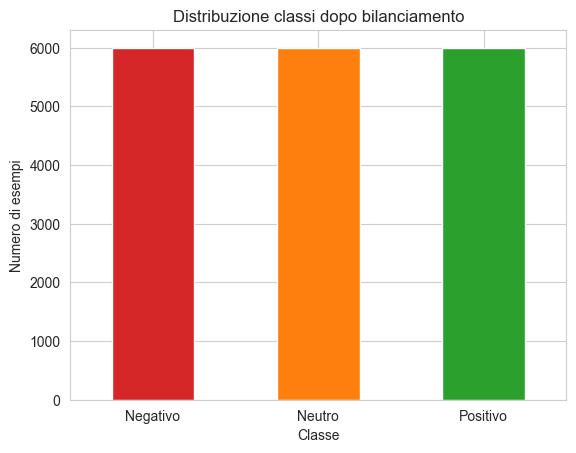

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

# ad es. labels_bal è una lista di "__label__NEG"/"__label__NEU"/"__label__POS"
s = pd.Series(labels_bal)

label_to_int = {
    "__label__NEG": 'Negativo',
    "__label__NEU": 'Neutro',
    "__label__POS": 'Positivo'
}
counts = s.map(label_to_int).value_counts().sort_index()

counts.plot(kind="bar", color=["tab:red", "tab:orange", "tab:green"])
plt.xlabel("Classe")
plt.ylabel("Numero di esempi")
plt.xticks(rotation=0)  # etichette orizzontali
plt.title("Distribuzione classi dopo bilanciamento")
plt.show()


In [113]:
def save_fasttext_file(texts, labels, path):
    with open(path, "w", encoding="utf-8") as f:
        for t, lab in zip(texts, labels):
            t_clean = " ".join(t.split())
            f.write(f"{lab} {t_clean}\n")

save_fasttext_file(texts_bal, labels_bal, "train_ft_balanced.txt")


In [126]:
import fasttext
# ----------------------------------------------------------------------
# Passaggio 5: Addestramento del Modello FastText in Python
# ----------------------------------------------------------------------

print(f"\nInizio addestramento FastText sul file: train_ft_balanced.txt")

# Addestra il modello utilizzando la funzione 'train_supervised'
model = fasttext.train_supervised(
    input='train_ft_balanced.txt',
    lr=0.1,             # Learning rate
    epoch=25,           # Numero di epoche
    wordNgrams=2,       # Usa n-grammi di parola di dimensione 2
    dim=100,            # Dimensione del vettore embedding
    loss='softmax',     # Funzione di perdita per classificazione multi-classe
    verbose=2,          # Livello di verbosità per il logging
    minCount=1          # Considera tutte le parole, anche quelle rare
)

print(f"Modello FastText addestrato e salvato")

# Salva il modello su disco
model.save_model("fasttext_sentiment_model.bin")
# Valutazione
result = model.test("test_ft.txt")
print("Precision:", result[1])
print("Recall:", result[2])



Inizio addestramento FastText sul file: train_ft_balanced.txt


Read 2M words
Number of words:  67817
Number of labels: 3
Progress: 100.0% words/sec/thread:  680911 lr:  0.000000 avg.loss:  0.148055 ETA:   0h 0m 0s


Modello FastText addestrato e salvato
Precision: 0.8333739936569895
Recall: 0.8333739936569895


In [119]:
test_df = pd.DataFrame({
    'Review': X_test.astype(str).tolist(),
    'FastText_Label': y_test.tolist()
})
print(test_df.head())
# ----------------------------------------------------------------------
# Passaggio 7: Valutazione Completa con Report (Opzione 2: Scikit-learn)
# ----------------------------------------------------------------------

# Estrai le vere etichette dal file di test
y_true_labels = test_df['FastText_Label'].tolist()

# Usa il modello per prevedere le etichette per l'intero set di test
y_pred_labels, _ = model.predict(test_df['Review'].tolist())

# 3. Mappa stringhe fastText -> codici numerici 0/1/2
label_to_int = {
    "__label__NEG": 0,
    "__label__NEU": 1,
    "__label__POS": 2
}

# Pulisci le etichette vere
y_true_clean = [
    lab if lab.startswith("__label__") else "__label__" + lab
    for lab in y_true_labels
]
y_true_int = [label_to_int[lab] for lab in y_true_clean]

# 4. Pulisci le etichette predette
y_pred_int = []
for labs in y_pred_labels:
    if not labs:
        # fallback: neutro (1) se per qualche motivo non c'è predizione
        y_pred_int.append(1)
    else:
        lab = labs[0]  # top-1
        if not lab.startswith("__label__"):
            lab = "__label__" + lab
        y_pred_int.append(label_to_int[lab])

# 5. Report sklearn
target_names = ['Negativo (0)', 'Neutro (1)', 'Positivo (2)']

print("\n--- Report di Classificazione (Scikit-learn) ---")
print(classification_report(y_true_int, y_pred_int, target_names=target_names))

                                              Review FastText_Label
0  amazing hotel believe good reviews hotel fanta...   __label__POS
1  basic ok n't expect luxury ok place stay, room...   __label__NEU
2  perfect, ca n't recommend place, great locatio...   __label__POS
3  aqua palms big disappointment stopped hawaii w...   __label__NEU
4  great hotel great hotel centrally located unio...   __label__POS

--- Report di Classificazione (Scikit-learn) ---
              precision    recall  f1-score   support

Negativo (0)       0.74      0.80      0.77       643
  Neutro (1)       0.36      0.40      0.38       437
Positivo (2)       0.94      0.91      0.92      3019

    accuracy                           0.84      4099
   macro avg       0.68      0.70      0.69      4099
weighted avg       0.85      0.84      0.84      4099

